## was studed on kaggle https://www.kaggle.com/code/henta1/ner-with-bert/settings ##

In [2]:
import tensorflow  as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

!pip install transformers
import transformers
from transformers import BertTokenizerFast, BertConfig
from transformers import TFBertModel

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


2023-02-19 16:48:53.999001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-19 16:48:53.999073: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
df = pd.read_csv("/kaggle/input/gamespot-ner/gamespot_ner.csv", encoding="latin-1")

In [5]:
dataframe = pd.read_csv("/kaggle/input/gamespot-ner/gamespot_ner.csv", encoding="latin-1")

In [6]:
len(np.unique(df['sentence']))

64386

In [7]:
pie = dataframe['tag'].value_counts()
px.pie(names = pie.index,values= pie.values,hole = 0.5,title ='Total Count of Tags')

In [8]:
def process_data(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df = df.dropna()

    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, 'tag'] = enc_tag.fit_transform(df['tag'])
    
    df = df.groupby("sentence").apply(lambda x: [list(x['word']), list(x['tag'])]).apply(pd.Series)
    df = df[df[1].apply(lambda x: len(x) < 110)]  # there are sentences with 3000+ number of words.  

    sentences = df[0].apply(list).values
    tag = df[1].apply(list).values
    return sentences, tag, enc_tag

sentence, tag, enc_tag = process_data("/kaggle/input/gamespot-ner/gamespot_ner.csv")

In [9]:
MAX_LEN = 128

In [10]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
def tokenize(data, max_len=MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')
                        
        
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
X_train,X_test,y_train,y_test = train_test_split(sentence, tag, random_state=42, test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((56844,), (6316,), (56844,), (6316,))

In [12]:
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)

100%|██████████| 56844/56844 [00:22<00:00, 2519.27it/s]


In [13]:
val_input_ids, val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 6316/6316 [00:02<00:00, 2682.30it/s]


In [14]:
# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (MAX_LEN-len(y_train[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{128}

In [15]:
# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (MAX_LEN-len(y_test[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{128}

In [16]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(5,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [17]:
with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    model = create_model(bert_model, MAX_LEN)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


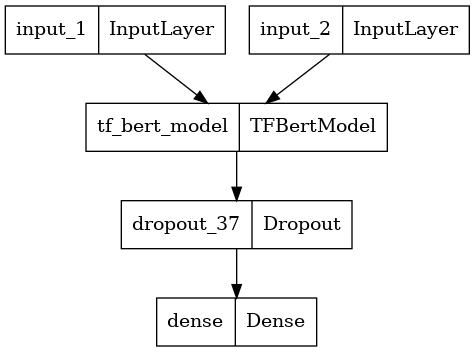

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
input_ids.shape

(56844, 128)

In [21]:
attention_mask.shape

(56844, 128)

In [22]:
np.array(train_tag).shape

(56844, 128)

In [23]:
early_stopping = EarlyStopping(mode='min',patience=5)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 1,callbacks = early_stopping,verbose = True)

1777/1777 [==============================] - 38612s 22s/step - loss: 0.0663 - accuracy: 0.9788 - val_loss: 0.0284 - val_accuracy: 0.9905


In [24]:
model.save_weights("ner_bert_weights")

In [26]:
def pred(val_input_ids,val_attention_mask):
    return model.predict([val_input_ids,val_attention_mask])

In [27]:
def testing(val_input_ids,val_attention_mask,enc_tag,y_test):
    val_input = val_input_ids.reshape(1,128)
    val_attention = val_attention_mask.reshape(1,128)
    
    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    print("Original Text : ",str(sentence))
    print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    print("Original Tags : " ,str(true_enc_tag))
    print("\n")
    
    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1) 
    pred_without_pad = pred_with_pad[pred_with_pad>0]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)
    print("Predicted Tags : ",pred_enc_tag)

In [43]:
i = 25
testing(val_input_ids[i],val_attention_mask[i],enc_tag,y_test[i])

Original Text :  [CLS] top gun maverick was released 36 years after the original film and is set in the modern day [SEP]


Original Tags :  ['B-g' 'I-g' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O']


1/1 [==============================] - 0s 326ms/step
Predicted Tags :  ['B-g' 'I-g' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O']
